## Extract features

In [40]:
def extract_features(im, im_mask):
    
    # Assymmetry
    asymmetry = mean_asymmetry(im_mask)
    
    # Color
    col_r, col_g, col_b = color_var(im, im_mask)
    
    # Compactness
    compactness = compactness_score(im_mask)
    
    # Convexity
    convexity = convexity_score(im_mask)
    
    return np.array([asymmetry, col_r, col_g, col_b, compactness, convexity], dtype=np.float16)

## Process Images

In [ ]:
import os
from os.path import isfile, join

import pandas as pd

import numpy as np

from prep_image import prep_im, prep_gt
import matplotlib.pyplot as plt

# Import feature 
from asymmetry import mean_asymmetry
from color import color_var
from compactness_score import compactness_score
from convexity import convexity_score

In [31]:
file_data = 'metadata.csv'
image_folder = 'test_images'

In [33]:
file_features = 'feature_data.csv'

In [34]:
# Image paths
image_ids = [f for f in os.listdir(image_folder) if isfile(join(image_folder, f))]
n_images = len(image_ids)

In [35]:
# Extract image ids and labels
df = pd.read_csv(file_data)

In [36]:
labels = []
for img_id in image_ids:
    if img_id in list(df['img_id']):
        mask = df['img_id']==img_id
        labels.append(df.loc[mask,'diagnostic'].iloc[0]) # Problem

In [38]:
# Extract feature
feature_names = ['assymmetry', 'color_r', 'color_g', 'color_b', 'compactness', 'convexity']
features_n = len(feature_names)
features = np.zeros([n_images, features_n], dtype = np.float16)

In [41]:
# Extract feature
images = []
for i in range(len(image_ids)):
    
    # Get maks
    im = prep_im(image_ids[i], image_folder + os.sep, output_shape = (300,300))
    arr = np.asarray(im)
    images.append(arr)
    
    im_mask = prep_gt(image_ids[i].split('.')[0], image_folder + '_groundtruths/', output_shape = (300,300))

    # Extract features
    x = extract_features(im, im_mask)
    features[i,:] = x

In [42]:
# Save image_ids and features in a file
df_features = pd.DataFrame(features, columns = feature_names)
#df_features.to_csv(file_features, index = False)

In [50]:
features[:,-1]

array([-0.007, -0.007,  0.025,  0.083, -0.166,  0.162, -0.006,  0.119,
        0.016,  0.068,  0.053,  0.002,  0.057, -0.079, -0.007, -0.003,
        0.048,  0.003,  0.622,  0.05 ,  0.143,  0.02 ,  0.013, -0.006,
        0.005,  0.012,  0.009,  0.04 ,  0.161,  0.162,  0.047, -0.019,
        0.08 ,  0.02 ,  0.081,  0.014,  0.08 , -0.01 , -0.001, -0.003,
       -0.005, -0.016, -0.001,  0.041, -0.01 ,  0.072, -0.001,  0.133,
        0.121,  0.032, -0.008,  0.05 , -0.012,  0.022,  0.008, -0.003,
        0.068,  0.171,  0.039, -0.011,  0.052,  0.033,  0.016,  0.083,
        0.164,  0.107, -0.012,  0.05 , -0.014,  0.357, -0.003,  0.038,
        0.028,  0.046,  0.026,  0.094,  0.242,  0.05 ,  0.141, -0.006,
        0.017, -0.004, -0.001,  0.029, -0.004,  0.035,  0.076,  0.125,
       -0.004,  0.331], dtype=float16)

In [56]:
df_features

,assymmetry,color_r,color_g,color_b,compactness,convexity
0,0.200684,0.000963,0.001459,0.001370,0.737793,-0.007000
1,0.190430,0.000501,0.002333,0.002220,0.729980,-0.007000
2,0.216553,0.002441,0.002157,0.001656,0.749023,0.024994
3,0.236816,0.001623,0.004570,0.004230,0.810059,0.083008
4,0.263184,0.001086,0.002434,0.002497,0.676758,-0.166016
...,...,...,...,...,...,...
85,0.178345,0.003025,0.009186,0.011055,0.741211,0.035004
86,0.127686,0.000061,0.001193,0.000849,0.788086,0.075989
87,0.212036,0.003263,0.010963,0.008514,0.833984,0.125000
88,0.218384,0.003323,0.014473,0.019730,0.736816,-0.004002


In [87]:
mask = features[:,-1] == min(features[:,-1])
features[4]

array([ 0.2632  ,  0.001086,  0.002434,  0.002497,  0.677   , -0.166   ],
      dtype=float16)

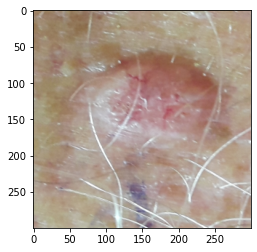

In [95]:
plt.imshow(images[-2])

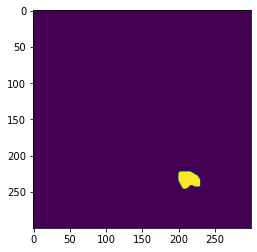

In [99]:
mask = prep_gt(image_ids[-2].split('.')[0], image_folder + '_groundtruths/', output_shape = (300,300))
plt.imshow(mask)

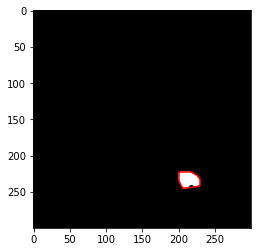

557
641.7778177135323


In [100]:
from convexity import show_convex_hull
from scipy.spatial import ConvexHull
show_convex_hull(mask)
print(np.count_nonzero(mask))
coords = np.transpose(np.nonzero(mask))
print(ConvexHull(coords).volume+ConvexHull(coords).area)

In [72]:
np.unique(mask)

array([0, 1])

In [102]:
1-557/641

0.13104524180967236

## Train classifier

In [ ]:
import os
import pandas as pd
import numpy as np

# Default packages for the minimum example
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score #example for measuring performance


import pickle #for saving/loading trained classifiers

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size= 0.2, random_state =1,stratify = y)

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 10)

# Train it --> need to define y first
clf.fit(X_train_transformed, y_train)

# Predict on validation dataset and measure accuracy, f1-score
clf.predict(X_test_transformed);

print(clf.score(X_test_transformed, y_test))

## Evaluate classifier

In [ ]:
import pickle #for loading your trained classifier

from extract_features import extract_features #our feature extraction

# The function that should classify new images. 
# The image and mask are the same size, and are already loaded using plt.imread
def classify(img, mask):
    
    
     #Resize the image etc, if you did that during training
    
     #Extract features (the same ones that you used for training)
     x = extract_features(img, mask)
         
     
     #Load the trained classifier
     classifier = pickle.load(open('groupXY_classifier.sav', 'rb'))
    
    
     #Use it on this example to predict the label AND posterior probability
     pred_label = classifier.predict(x)
     pred_prob = classifier.predict_proba(x)
     
     
     #print('predicted label is ', pred_label)
     #print('predicted probability is ', pred_prob)
     return pred_label, pred_prob

In [ ]:
# Call in a loop